<a href="https://colab.research.google.com/github/elbixos/M2_Connectionnisme/blob/master/DeepMim/Cours/DeepMim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Commencons par charger nos données

In [7]:

import pandas as pd



dataset_path = 'evalMim.csv'
column_names = ['line1','line2','line3','line4','eval']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()


,line1,line2,line3,line4,eval
138,7,5,1,1,1
139,7,5,2,0,-1
140,7,5,2,1,1
141,7,5,3,0,1
142,7,5,3,1,-1


Puis, on sépare le label (eval) des caractéristiques

In [8]:


train_labels = dataset.pop('eval')
dataset.tail()


,line1,line2,line3,line4
138,7,5,1,1
139,7,5,2,0
140,7,5,2,1
141,7,5,3,0
142,7,5,3,1


On peut aussi voir les labels

In [9]:

train_labels.tail()


138    1
139   -1
140    1
141    1
142   -1
Name: eval, dtype: int64

On peut maintenant construire le modele

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

def build_model():
  model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[4]),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()


Et regarder sa tete...

In [27]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________


Essayons quelques prédictions

In [28]:
example_batch = dataset[:5]
example_result = model.predict(example_batch)
example_result

array([[ 0.        ],
       [-0.12302747],
       [-0.09751719],
       [-0.24605495],
       [-0.19692932]], dtype=float32)

Commencons l'entrainement

In [32]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 4000

history = model.fit(
  dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Voyons ce qui s'est passé

In [33]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
3995,0.047705,0.159880,0.047705,2.107761,1.113633,2.107761,3995
3996,0.050762,0.165680,0.050762,2.100166,1.119520,2.100166,3996
3997,0.027089,0.112095,0.027089,2.092523,1.112024,2.092523,3997
3998,0.055009,0.175068,0.055009,2.012269,1.114466,2.012269,3998
3999,0.024893,0.098328,0.024892,2.070687,1.147078,2.070687,3999


Avec une courbe

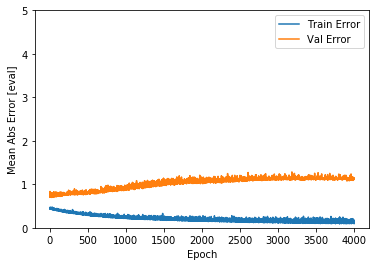

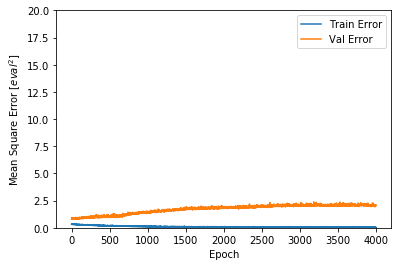

In [34]:
import matplotlib.pyplot as plt


def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [eval]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$eval^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


Revoyons ce qui se passe maintenant en prédiction

In [36]:
example_batch = dataset[:5]
example_result = model.predict(example_batch)
example_result


array([[ 0.983209  ],
       [-0.9877565 ],
       [ 0.99828064],
       [ 1.024215  ],
       [ 0.9864789 ]], dtype=float32)

Et on attendait

In [37]:

examples_labels = train_labels[:5]
examples_labels

0    1
1   -1
2    1
3    1
4    1
Name: eval, dtype: int64

Ca semble pas mal !

Essayons de sauver le model pendant l'apprentissage

In [39]:
import os

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)



# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot(),cp_callback])



.
Epoch 00001: saving model to training_1/cp.ckpt
.
Epoch 00002: saving model to training_1/cp.ckpt
.
Epoch 00003: saving model to training_1/cp.ckpt
.
Epoch 00004: saving model to training_1/cp.ckpt
.
Epoch 00005: saving model to training_1/cp.ckpt
.
Epoch 00006: saving model to training_1/cp.ckpt
.
Epoch 00007: saving model to training_1/cp.ckpt
.
Epoch 00008: saving model to training_1/cp.ckpt
.
Epoch 00009: saving model to training_1/cp.ckpt
.
Epoch 00010: saving model to training_1/cp.ckpt
.
Epoch 00011: saving model to training_1/cp.ckpt
.
Epoch 00012: saving model to training_1/cp.ckpt
.
Epoch 00013: saving model to training_1/cp.ckpt
.
Epoch 00014: saving model to training_1/cp.ckpt
.
Epoch 00015: saving model to training_1/cp.ckpt
.
Epoch 00016: saving model to training_1/cp.ckpt
.
Epoch 00017: saving model to training_1/cp.ckpt
.
Epoch 00018: saving model to training_1/cp.ckpt
.
Epoch 00019: saving model to training_1/cp.ckpt
.
Epoch 00020: saving model to training_1/cp.ckpt

Pour charger ce model, on ferait

In [45]:
# Create a basic model instance
model2 = build_model()

# Loads the weights
model2.load_weights(checkpoint_path)

Testons ce modele :

In [46]:
example_batch = dataset[:5]
example_result = model.predict(example_batch)
example_result


array([[ 1.0022886],
       [-1.0295156],
       [ 1.013531 ],
       [ 1.0269231],
       [ 1.0376854]], dtype=float32)

pour un résultat attendu de :

In [47]:

examples_labels = train_labels[:5]
examples_labels

0    1
1   -1
2    1
3    1
4    1
Name: eval, dtype: int64

On aurait aussi pu faire...

In [48]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
model3 = build_model()

# Restore the weights
model3.load_weights('./checkpoints/my_checkpoint')

# Evaluate the model
loss,mae,mse= model3.evaluate(dataset,  train_labels, verbose=2)
print(loss)


143/143 - 0s - loss: 0.4343 - mean_absolute_error: 0.3283 - mean_squared_error: 0.4343
0.43429314631682175


Voyons une utilisation en prédiction telle qu'elle serait faite dans le jeu...


In [56]:
dataset.tail()

,line1,line2,line3,line4
138,7,5,1,1
139,7,5,2,0
140,7,5,2,1
141,7,5,3,0
142,7,5,3,1
